In [1]:
import sys
import pennylane as qml
from pennylane import numpy as np
from math import pi
from sklearn import datasets
import scipy
import numpy as np
import time
import math

In [2]:
numQubits = 4
depth = 9    ##using d = (D+1)*S
d = 40

In [3]:
dev = qml.device("default.qubit", wires=numQubits)

In [4]:
def add_layerRZ(data):
    for i in range(numQubits):
        qml.RZ(data[i], wires = i)

def add_layerRZZ(data):
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])
            qml.RZ((pi-data[i])*(pi-data[j]), wires = j)
            qml.CNOT(wires = [i, j])

def make_feature_map(data):
    for i in range(numQubits):
        qml.Hadamard(wires = i)
    for i in range(2):
        add_layerRZ(data)
        add_layerRZZ(data)

In [5]:
def add_cnots():
    for i in range(0, numQubits-1):
        for j in range(i+1, numQubits):
            qml.CNOT(wires = [i, j])

def add_layerRY(params):
    for qubit in range(numQubits):
        qml.RY(params[qubit], wires = qubit)
        
def make_variationalCircuit(params):
    add_cnots()
    add_layerRY(params)

In [6]:
def make_final_circuit(data, params, depth):
    make_feature_map(data)
    add_layerRY(params[0:numQubits])
    for i in range(depth):
        make_variationalCircuit(params[numQubits*(i+1):numQubits*(i+2)])

In [7]:
@qml.qnode(dev)
def qnode(params):
    make_final_circuit(data, params, depth)
    return qml.expval(qml.PauliX(1))

In [8]:
@qml.qnode(dev)
def fubini_qnode(data, params,depth):
    make_final_circuit(data, params,depth)
    return qml.state()

In [9]:
def fubini_calculate(data, params,depth):
    fubini = np.zeros([d, d], dtype=np.float64)
    base = np.conj(fubini_qnode(data,params,depth))
    for i in range(d):
        for j in range(d):
            params[i] += np.pi/2
            params[j] += np.pi/2
            plusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] -= np.pi
            plusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[i] -= np.pi
            minusminus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            params[j] += np.pi
            minusplus = np.abs(np.dot(base, fubini_qnode(data, params,depth))) ** 2
            fubini[i, j] = (-plusplus-minusminus+plusminus+minusplus)/8
            params[i] += np.pi/2
            params[j] -= np.pi/2
    return fubini

In [10]:
fubini_matrices = []
eigen_vals = []
paramsV = []
dataV = []

In [12]:
start_qfi = time.time()

for i in range(300, 500):
    print(i)
    np.random.seed(i)
    data = np.random.uniform(-1,1,numQubits) 
    dataV.append(data)
    params = np.random.uniform(-1,1,d)
    paramsV.append(params)
    fubini = fubini_calculate(data, params, depth)
    fubini_matrices.append(fubini)
    eigvals,eigvecs=scipy.linalg.eigh(fubini)
    eigen_vals.append(eigvals)
    
end_qfi = time.time()
print(end_qfi - start_qfi)


300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
27426.176276683807


In [46]:
import pickle
file_name = "PickleFiles/QNN40300.pkl"
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

eigen_300 = loaded_list[2]
fubini_matrices.extend(loaded_list[1])
print(len(fubini_matrices))

500


In [47]:
eigenVals = eigen_vals[0:200]
eigenVals.extend(eigen_300)
eigen_values = []
for i in range(0,len(eigenVals)):
    for j in range(len(eigenVals[0])):
        eigen_values.append(4*eigenVals[i][j])

In [48]:
len(eigen_values)

20000

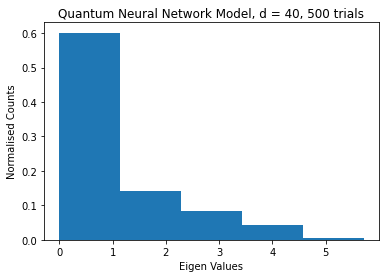

In [49]:
import matplotlib.pyplot as plt
plt.hist(eigen_values, bins = 5, density=True)
plt.title("Quantum Neural Network Model, d = 40, 500 trials")
plt.xlabel("Eigen Values")
plt.ylabel("Normalised Counts")
plt.savefig("Plots/QNN40500")
plt.show()

In [50]:
import pickle
file_name = "PickleFiles/QNN40500.pkl"

open_file = open(file_name, "wb")
pickle.dump([data,fubini_matrices,eigen_vals,paramsV,eigen_values], open_file)
pickle.dump(fubini_matrices, open_file)
open_file.close()


In [51]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()
print(len(loaded_list[1]))

500


In [52]:
eigvals_bw01=[eigen_values[i] for i in range(len(eigen_values)) if eigen_values[i] <= 1]

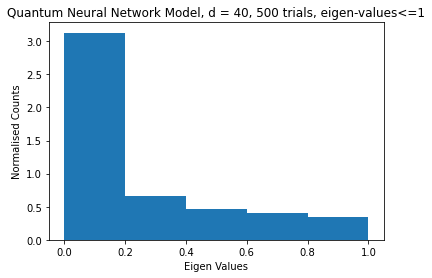

In [53]:
import matplotlib.pyplot as plt
plt.hist(eigvals_bw01, bins = 5, density=True)
plt.title("Quantum Neural Network Model, d = 40, 500 trials, eigen-values<=1")
plt.xlabel("Eigen Values")
plt.ylabel("Normalised Counts")
plt.savefig("QNN40500bw01")
plt.show()